Implement a Gaze-LLE to keep track of who is looking at who

In [ ]:
import cv2
import numpy as np
import os
import glob
from typing import List, Tuple, Optional

def create_video_from_frames(
    input_pattern: str, 
    output_filename: str, 
    fps: float = 30.0, 
    crop_frames: Optional[dict] = None
) -> None:
    """
    Create a video from PNG frames with optional cropping for specific frames.
    
    Args:
        input_pattern: Glob pattern for input frames (e.g., 'frame_*.png')
        output_filename: Path to save the output video
        fps: Frames per second for the output video
        crop_frames: Optional dictionary mapping frame indices to crop regions
                     Format: {frame_index: (x, y, width, height)}
    """
    # Get all matching frame files and sort them
    frame_files = sorted(glob.glob(input_pattern))
    
    if not frame_files:
        print(f"No frames found matching pattern: {input_pattern}")
        return
    
    # Read the first frame to get dimensions
    first_frame = cv2.imread(frame_files[0])
    height, width, layers = first_frame.shape
    
    # Define video codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'XVID' for .avi
    video_writer = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))
    
    # Process each frame
    for i, frame_file in enumerate(frame_files):
        print(f"Processing frame {i+1}/{len(frame_files)}: {frame_file}")
        
        # Read the frame
        frame = cv2.imread(frame_file)
        
        # Apply cropping if specified for this frame
        if crop_frames and i in crop_frames:
            x, y, w, h = crop_frames[i]
            # Crop the frame
            cropped = frame[y:y+h, x:x+w]
            
            # Resize back to original dimensions to maintain video size
            frame = cv2.resize(cropped, (width, height), interpolation=cv2.INTER_AREA)
        
        # Write the frame to the video
        video_writer.write(frame)
    
    # Release resources
    video_writer.release()
    print(f"Video saved as {output_filename}")

# Example usage
if __name__ == "__main__":
    # Define input pattern for your frames
    input_pattern = "frame_*.png"  # Adjust to match your file naming pattern
    
    # Define output file name
    output_filename = "output_video.mp4"
    
    # Optional: Define frames to crop
    # Format: {frame_index: (x, y, width, height)}
    # Example: Crop frames 3 and 5
    crop_frames = {
        3: (100, 50, 800, 600),  # Crop frame_0003.png
        5: (200, 100, 600, 400)  # Crop frame_0005.png
    }
    
    # Create the video
    create_video_from_frames(
        input_pattern=input_pattern,
        output_filename=output_filename,
        fps=24.0,  # Adjust FPS as needed
        crop_frames=crop_frames
    )

In [4]:
import cv2
import os

def split_video_into_frames(video_path, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video file was opened correctly
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Get the frame rate (fps) of the video
    fps = cap.get(cv2.CAP_PROP_FPS)

    frame_count = 0
    frame_interval = int(fps)  # Capture 1 frame per second

    while True:
        # Set the position to the next frame at the interval
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count * frame_interval)

        # Read a frame from the video
        ret, frame = cap.read()

        # If the frame was successfully read
        if ret:
            # Generate filename for the frame
            frame_filename = os.path.join(output_folder, f"frame_pbm_{frame_count:04d}.png")

            # Save the frame as an image
            cv2.imwrite(frame_filename, frame)

            # Print frame number
            print(f"Frame {frame_count} saved as {frame_filename}")

            # Increment frame count
            frame_count += 1
        else:
            # End of the video, break the loop
            break

    # Release the video capture object
    cap.release()
    print(f"Video split into {frame_count} frames.")

# Example usage
video_path = "/Users/rgopalam/Desktop/plaque_boy_max.mp4"  # Replace with your video file path
output_folder = "/Users/rgopalam/Desktop/office"  # Folder to save the frames

split_video_into_frames(video_path, output_folder)

Frame 0 saved as /Users/rgopalam/Desktop/office/frame_pbm_0000.png
Frame 1 saved as /Users/rgopalam/Desktop/office/frame_pbm_0001.png
Frame 2 saved as /Users/rgopalam/Desktop/office/frame_pbm_0002.png
Frame 3 saved as /Users/rgopalam/Desktop/office/frame_pbm_0003.png
Frame 4 saved as /Users/rgopalam/Desktop/office/frame_pbm_0004.png
Frame 5 saved as /Users/rgopalam/Desktop/office/frame_pbm_0005.png
Frame 6 saved as /Users/rgopalam/Desktop/office/frame_pbm_0006.png
Frame 7 saved as /Users/rgopalam/Desktop/office/frame_pbm_0007.png
Frame 8 saved as /Users/rgopalam/Desktop/office/frame_pbm_0008.png
Frame 9 saved as /Users/rgopalam/Desktop/office/frame_pbm_0009.png
Video split into 10 frames.


Using cache found in /Users/rgopalam/.cache/torch/hub/fkryan_gazelle_main
Using cache found in /Users/rgopalam/.cache/torch/hub/facebookresearch_dinov2_main


Successfully loaded face for Jason
Successfully loaded face for Buddy
Processing 1 frames...
Processing frame 1/1: frame_0000.png
Face 0 matched to: Jason with score: 0.4075
Face 1 matched to: Buddy with score: 0.5069
Running gaze detection model...
Frame 0 faces: ['Jason', 'Buddy']
Visualization data for frame 0:
  - Names: ['Jason', 'Buddy']
  - Emotions: ['neutral', 'fear']
  - InOut scores: [0.9788452386856079, 0.7889425158500671]
Names passed to visualize_all: ['Jason', 'Buddy']
Saved visualization for frame_0000.png to output/viz_frame_0000.png
Analysis complete!


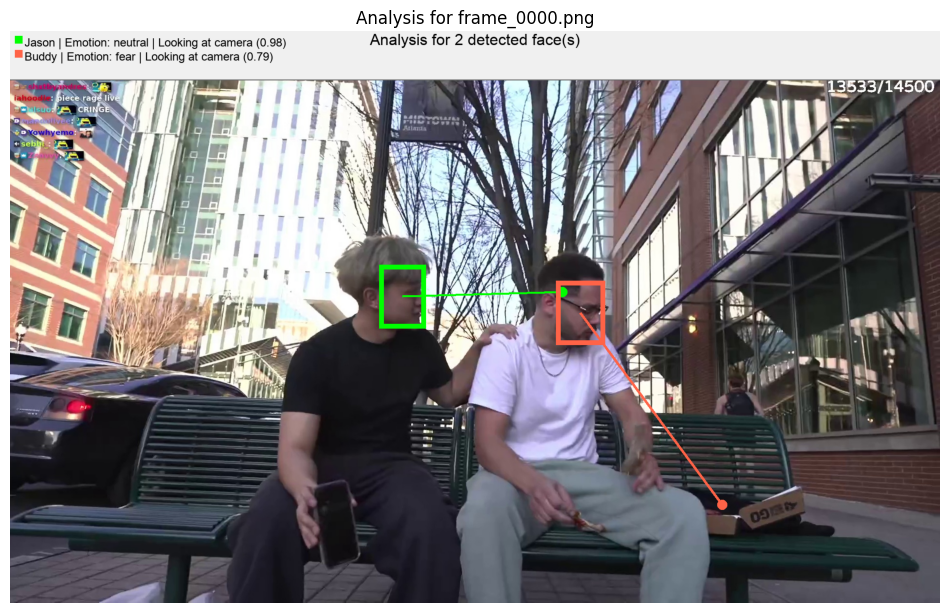


Profile Summary:
Profile 1 (Jason): Appeared in 1 frames
Profile 2 (Buddy): Appeared in 1 frames


In [15]:
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision import transforms
import numpy as np
from retinaface import RetinaFace
from deepface import DeepFace
from scipy.spatial.distance import cosine
import cv2
import matplotlib.pyplot as plt
import os
from io import BytesIO

# Define transform for gaze detection model
transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
])

device = 'cuda' if torch.cuda.is_available() else 'cpu'


def load_known_faces(image_paths):
    """
    Load known faces and generate embeddings using RetinaFace for detection.
    :param image_paths: Dictionary of {name: image_path} pairs.
    :return: Dictionary of {name: embedding} pairs.
    """
    known_faces = {}
    for name, image_path in image_paths.items():
        try:
            # Load the image
            face_image = cv2.imread(image_path)
            if face_image is None:
                print(f"Could not load image for {name} at {image_path}")
                continue
                
            # Detect faces using RetinaFace instead of OpenCV's Haar cascade
            resp = RetinaFace.detect_faces(face_image)
            
            if resp:
                # Get the first face's bounding box
                bbox = resp['face_1']['facial_area']
                x1, y1, x2, y2 = bbox
                
                # Extract face ROI
                face_roi = face_image[y1:y2, x1:x2]
                
                # Generate embedding using 'skip' as detector_backend
                embedding = DeepFace.represent(face_roi, model_name='Facenet512', 
                                           detector_backend='skip', 
                                           enforce_detection=False)
                known_faces[name] = np.array(embedding[0]['embedding'])
                print(f"Successfully loaded face for {name}")
            else:
                print(f"No face detected for {name} in {image_path}")
        except Exception as e:
            print(f"Error loading face for {name}: {e}")
    return known_faces

def match_known_face(face_embedding, known_faces):
    """
    Match a detected face embedding to the most similar known face.
    :param face_embedding: The embedding of the detected face.
    :param known_faces: Dictionary of {name: embedding} pairs.
    :return: Name of the most similar face and the similarity score.
    """
    best_match = None
    best_score = float('inf')  # Lower distance is better
    
    for name, known_embedding in known_faces.items():
        distance = cosine(known_embedding, face_embedding)
        if distance < best_score:
            best_score = distance
            best_match = name
    
    return best_match, best_score

def get_face_embedding(face_roi):
    """Generate an embedding for the given face ROI."""
    try:
        # Since we already have the face ROI, skip the detection step
        embedding = DeepFace.represent(face_roi, model_name='Facenet512', 
                                    detector_backend='skip', 
                                    enforce_detection=False)
        return np.array(embedding[0]['embedding'])
    except Exception as e:
        print(f"Embedding error: {e}")
        return None

def analyze_emotions(face_roi):
    """Analyze emotions using DeepFace."""
    try:
        result = DeepFace.analyze(face_roi, actions=['emotion'], 
                               detector_backend='skip',
                               enforce_detection=False)
        return result[0]['dominant_emotion']
    except Exception as e:
        print(f"Emotion analysis error: {e}")
        return "Unknown"

def visualize_all(pil_image, heatmaps, bboxes, inout_scores=None, emotions=None, names=None, inout_thresh=0.5):
    """
    Create a visualization with bounding boxes, gaze points, and labels.
    
    :param pil_image: PIL Image to visualize on
    :param heatmaps: Tensor of heatmaps for each face
    :param bboxes: List of bounding boxes for each face
    :param inout_scores: List of in-frame scores for each face (optional)
    :param emotions: List of emotions for each face (optional)
    :param names: List of names for each face (optional)
    :param inout_thresh: Threshold for considering gaze to be in-frame
    :return: PIL Image with visualization
    """
    print("Names passed to visualize_all:", names)
    
    colors = ['lime', 'tomato', 'cyan', 'fuchsia', 'yellow']
    
    # Create a new image with extra space at the top for headers
    width, height = pil_image.size
    header_height = 100  # Adjustable based on your preference
    
    # Create a new image with white background for the header area
    new_image = Image.new("RGBA", (width, height + header_height), (255, 255, 255, 255))
    new_image.paste(pil_image, (0, header_height))
    
    # Convert to RGBA for drawing
    overlay_image = new_image.convert("RGBA")
    draw = ImageDraw.Draw(overlay_image)
    
    # Draw header area with a light gray background
    draw.rectangle([0, 0, width, header_height], fill=(240, 240, 240, 255))
    
    # Draw a line to separate header from image
    draw.line([(0, header_height), (width, header_height)], fill=(100, 100, 100, 255), width=2)
    
    # Prepare to write the face information in the header
    header_text = []
    
    for i in range(len(bboxes)):
        # Get bounding box
        bbox = bboxes[i]
        xmin, ymin, xmax, ymax = bbox
        
        # Convert normalized coordinates to pixel coordinates (adjusted for header)
        xmin_px, ymin_px = xmin * width, ymin * height + header_height
        xmax_px, ymax_px = xmax * width, ymax * height + header_height
        
        # Select color for this face
        color = colors[i % len(colors)]
        
        # Draw bounding box
        line_width = max(1, int(min(width, height) * 0.01))
        draw.rectangle([xmin_px, ymin_px, xmax_px, ymax_px], outline=color, width=line_width)
        
        # Prepare label text
        person_info = []
        if names is not None and i < len(names):
            person_info.append(f"{names[i]}")  # Just use the actual name
        else:
            person_info.append(f"Person {i+1}")
            
        if emotions is not None and i < len(emotions):
            person_info.append(f"Emotion: {emotions[i]}")
            
        if inout_scores is not None and i < len(inout_scores):
            if torch.is_tensor(inout_scores[i]):
                score_value = inout_scores[i].item()
            else:
                score_value = float(inout_scores[i])
            looking_at = "Looking at camera" if score_value > inout_thresh else "Not looking at camera"
            person_info.append(f"{looking_at} ({score_value:.2f})")
        
        # Add this face's info to the header text
        header_text.append((person_info, color))
        
        # Draw gaze direction if available and in-frame score is above threshold
        if heatmaps is not None and i < len(heatmaps):
            should_draw_gaze = True
            if inout_scores is not None and i < len(inout_scores):
                if torch.is_tensor(inout_scores[i]):
                    inout_value = inout_scores[i].item()
                else:
                    inout_value = float(inout_scores[i])
                should_draw_gaze = inout_value > inout_thresh
            
            if should_draw_gaze:
                # Convert heatmap to numpy if it's a tensor
                if torch.is_tensor(heatmaps[i]):
                    heatmap_np = heatmaps[i].detach().cpu().numpy()
                else:
                    heatmap_np = heatmaps[i]
                
                # Find max activation point in heatmap
                max_index = np.unravel_index(np.argmax(heatmap_np), heatmap_np.shape)
                gaze_target_y, gaze_target_x = max_index  # Heatmap indices are (y, x)
                
                # Convert heatmap indices to image coordinates
                gaze_target_x = gaze_target_x / heatmap_np.shape[1] * width
                gaze_target_y = gaze_target_y / heatmap_np.shape[0] * height + header_height
                
                # Calculate center of bounding box
                bbox_center_x = ((xmin + xmax) / 2) * width
                bbox_center_y = ((ymin + ymax) / 2) * height + header_height
                
                # Draw gaze point
                point_radius = max(1, int(min(width, height) * 0.01))
                draw.ellipse([(gaze_target_x-point_radius, gaze_target_y-point_radius), 
                              (gaze_target_x+point_radius, gaze_target_y+point_radius)], 
                             fill=color)
                
                # Draw line from face to gaze point
                line_width = max(1, int(min(width, height) * 0.005))
                draw.line([(bbox_center_x, bbox_center_y), (gaze_target_x, gaze_target_y)], 
                          fill=color, width=line_width)
    
    # Draw the header information
    try:
        # Try to load a better font
        font_size = 24
        try:
            font = ImageFont.truetype("Arial", font_size)
        except:
            # If Arial not available, try system default font
            font = ImageFont.load_default()
    except:
        # If loading default font fails, proceed without a font
        font = None
    
    # Draw the header text
    y_offset = 10
    for i, (person_info, color) in enumerate(header_text):
        # Draw a color box to match the bounding box color
        color_box_size = 15
        draw.rectangle([10, y_offset, 10 + color_box_size, y_offset + color_box_size], fill=color)
        
        # Draw the text with information
        text = " | ".join(person_info)
        draw.text((10 + color_box_size + 5, y_offset), text, fill="black", font=font)
        
        # Move to the next line
        y_offset += font_size + 5
    
    # Add a title at the top
    title_text = f"Analysis for {len(bboxes)} detected face(s)"
    title_font_size = 32
    try:
        title_font = ImageFont.truetype("Arial", title_font_size)
    except:
        title_font = font
    
    # Calculate position to center the title
    if title_font:
        title_width = title_font.getlength(title_text)
    else:
        # Approximate width if font metrics unavailable
        title_width = len(title_text) * title_font_size * 0.6
    
    title_x = (width - title_width) / 2
    draw.text((title_x, 0), title_text, fill="black", font=title_font)
    
    return overlay_image

def analyze_frames(image_paths, gaze_model, known_faces=None, output_dir=None):
    """
    Analyze a batch of frames with gaze detection, face recognition, and emotion analysis.
    
    :param image_paths: List of paths to frame images
    :param gaze_model: The pre-trained gaze detection model
    :param known_faces: Dictionary of {name: embedding} pairs for known people (optional)
    :param output_dir: Directory to save visualized results (optional)
    :return: Dictionary with analysis results for each frame
    """
    # Track profiles across frames
    profiles = {}
    
    # Store results for each frame
    results = {}
    
    # Initialize lists to hold image tensors and bounding boxes for batch processing
    img_tensors = []
    norm_bboxes = []
    frame_face_data = []  # Store face data for each frame
    
    print(f"Processing {len(image_paths)} frames...")
    
    # First pass: Process each frame to detect faces and get embeddings
    for frame_idx, image_path in enumerate(image_paths):
        print(f"Processing frame {frame_idx+1}/{len(image_paths)}: {image_path}")
        
        # Open image
        image = Image.open(image_path)
        
        # Get image dimensions (width and height)
        width, height = image.size
        
        # Convert image to numpy array for RetinaFace
        np_image = np.array(image)
        
        # Convert to OpenCV format for DeepFace
        cv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        
        # Detect faces using RetinaFace
        resp = RetinaFace.detect_faces(np_image)
        
        # Initialize frame result
        results[image_path] = {
            'faces': []
        }
        
        # Extract and process faces if detected
        frame_faces = []
        frame_norm_boxes = []
        
        if resp:
            for face_idx, face_key in enumerate(resp.keys()):
                # Get facial area
                facial_area = resp[face_key]['facial_area']
                x1, y1, x2, y2 = facial_area
                
                # Extract face ROI
                face_roi = cv_image[y1:y2, x1:x2]
                if face_roi.size == 0:
                    continue
                
                # Generate face embedding
                embedding = get_face_embedding(face_roi)
                if embedding is None:
                    continue
                
                # Analyze emotion
                emotion = analyze_emotions(face_roi)
                
                # Match to known face if provided - using the updated approach
                identity = None
                similarity_score = None
                if known_faces:
                    identity, similarity_score = match_known_face(embedding, known_faces)
                    print(f"Face {face_idx} matched to: {identity} with score: {similarity_score:.4f}")
                
                # Check if this face matches any existing profile (still using threshold for cross-frame tracking)
                profile_id = None
                for pid, profile in profiles.items():
                    distance = cosine(profile['embedding'], embedding)
                    if distance < EMBEDDING_THRESHOLD:
                        profile_id = pid
                        break
                
                # If no match, create a new profile
                if profile_id is None:
                    profile_id = len(profiles) + 1
                    profiles[profile_id] = {
                        'embedding': embedding,
                        'name': identity if identity else f"Person {profile_id}",
                        'frames_seen': []
                    }
                
                # Update profile information
                profiles[profile_id]['frames_seen'].append(frame_idx)
                if identity and profiles[profile_id].get('name', '').startswith('Person '):
                    profiles[profile_id]['name'] = identity
                
                # Store face data
                face_data = {
                    'bbox': (x1, y1, x2, y2),
                    'profile_id': profile_id,
                    'identity': identity,
                    'similarity_score': similarity_score,
                    'emotion': emotion,
                    'name': profiles[profile_id]['name']
                }
                
                frame_faces.append(face_data)
                
                # Normalize bbox for gaze model
                norm_bbox = np.array(facial_area) / np.array([width, height, width, height])
                frame_norm_boxes.append(norm_bbox)
            
            # Store the normalized boxes for this frame
            norm_bboxes.append(frame_norm_boxes)
        else:
            # If no faces detected, add empty entry
            norm_bboxes.append([])
        
        # Store face data for this frame
        frame_face_data.append(frame_faces)
        
        # Transform image for gaze model and add to batch
        img_tensor = transform(image).unsqueeze(0).to(device)
        img_tensors.append(img_tensor)
    
    # Run gaze model if we have images with faces
    gaze_output = None
    if img_tensors and any(len(boxes) > 0 for boxes in norm_bboxes):
        # Stack all image tensors into a single batch
        img_batch = torch.cat(img_tensors, dim=0)
        
        # Prepare input for gaze model
        input_data = {
            "images": img_batch,  # [batch_size, 3, 448, 448]
            "bboxes": norm_bboxes  # List of normalized bounding boxes for each image
        }
        
        # Run the gaze model on the batch
        print("Running gaze detection model...")
        with torch.no_grad():
            gaze_output = gaze_model(input_data)
    
    # Second pass: Process gaze detection results and create visualizations
    all_visualizations = {}
    
    for frame_idx, image_path in enumerate(image_paths):
        # Get face data for this frame
        faces = frame_face_data[frame_idx]
        results[image_path]['faces'] = []
        
        # Skip if no faces in this frame
        if not faces:
            continue
            
        # Open image for visualization
        image = Image.open(image_path)
        
        # Extract data for visualization
        frame_bboxes = []
        frame_names = []
        frame_emotions = []
        frame_inout_scores = []
        
        # Debug print to check faces data
        print(f"Frame {frame_idx} faces: {[face['name'] for face in faces]}")
        
        for face_data in faces:
            # Get normalized bounding box
            x1, y1, x2, y2 = face_data['bbox']
            width, height = image.size
            norm_bbox = (x1/width, y1/height, x2/width, y2/height)
            frame_bboxes.append(norm_bbox)
            
            # Get name and emotion
            name = face_data['name']
            frame_names.append(name)
            frame_emotions.append(face_data['emotion'])
            
            # Store complete face data in results
            complete_face_data = {
                'bbox': face_data['bbox'],
                'profile_id': face_data['profile_id'],
                'name': name,
                'similarity_score': face_data.get('similarity_score'),
                'emotion': face_data['emotion'],
                'gaze': {}
            }
            
            # Add gaze information if available
            if gaze_output:
                face_idx = faces.index(face_data)
                
                # Get in/out score
                if 'inout' in gaze_output and frame_idx < len(gaze_output['inout']) and face_idx < len(gaze_output['inout'][frame_idx]):
                    inout_score = gaze_output['inout'][frame_idx][face_idx].item()
                    frame_inout_scores.append(inout_score)
                    complete_face_data['gaze']['inout_score'] = inout_score
                    complete_face_data['gaze']['looking_at_camera'] = inout_score > 0.5
                else:
                    frame_inout_scores.append(None)
                
                # Get heatmap
                if 'heatmap' in gaze_output and frame_idx < len(gaze_output['heatmap']) and face_idx < len(gaze_output['heatmap'][frame_idx]):
                    heatmap = gaze_output['heatmap'][frame_idx][face_idx].cpu().numpy()
                    complete_face_data['gaze']['heatmap'] = heatmap.tolist()  # Convert to list for JSON serialization
            
            results[image_path]['faces'].append(complete_face_data)
        
        # Debug print before visualization
        print(f"Visualization data for frame {frame_idx}:")
        print(f"  - Names: {frame_names}")
        print(f"  - Emotions: {frame_emotions}")
        print(f"  - InOut scores: {frame_inout_scores}")
        
        # Create visualization if we have gaze data
        if gaze_output and 'heatmap' in gaze_output and frame_idx < len(gaze_output['heatmap']):
            # Get heatmaps for this frame
            frame_heatmaps = gaze_output['heatmap'][frame_idx]
            
            # Create visualization
            viz_image = visualize_all(
                image, 
                frame_heatmaps, 
                frame_bboxes, 
                frame_inout_scores, 
                frame_emotions, 
                frame_names
            )
            
            all_visualizations[image_path] = viz_image
            
            # Save visualization if output directory specified
            if output_dir:
                os.makedirs(output_dir, exist_ok=True)
                output_path = os.path.join(output_dir, f"viz_{os.path.basename(image_path)}")
                viz_image.save(output_path)
                print(f"Saved visualization for {image_path} to {output_path}")
    
    # Add overall profile information to results
    results['profiles'] = {pid: {
        'name': profile['name'],
        'frames_seen': profile['frames_seen']
    } for pid, profile in profiles.items()}
    
    # Add visualizations to results
    results['visualizations'] = all_visualizations
    
    print("Analysis complete!")
    return results

def display_results(results):
    """
    Display the analysis results including visualizations.
    
    :param results: Results dictionary from analyze_frames
    """
    # Display visualizations
    for image_path, viz_image in results.get('visualizations', {}).items():
        plt.figure(figsize=(12, 8))
        plt.imshow(viz_image)
        plt.title(f"Analysis for {os.path.basename(image_path)}")
        plt.axis('off')
        plt.show()
    
    # Display profile summary
    profiles = results.get('profiles', {})
    if profiles:
        print("\nProfile Summary:")
        for pid, profile in profiles.items():
            print(f"Profile {pid} ({profile['name']}): Appeared in {len(profile['frames_seen'])} frames")

# Example usage
if __name__ == "__main__":
    # Define paths to your frames
    image_paths = ["frame_0000.png",]
    
    # Load your gaze detection model
    # load Gaze-LLE model
    model, transform = torch.hub.load('fkryan/gazelle', 'gazelle_dinov2_vitl14_inout')

    model.eval()
    model.to('cpu')

    # Load known faces
    known_faces = load_known_faces({
        "Jason": "/Users/rgopalam/Desktop/office/jason.png",
        "Buddy": "/Users/rgopalam/Desktop/office/buddy.png"
    })
    
    # Analyze frames
    results = analyze_frames(image_paths, model, known_faces, output_dir="output")
    
    # Display results
    display_results(results)